# MadMiner particle physics tutorial

# Part 2b: Analyzing events at Delphes level

Johann Brehmer, Felix Kling, Irina Espejo, and Kyle Cranmer 2018-2019

In this second part of the tutorial, we'll generate events and extract the observables and weights from them. You have two options: In this notebook we'll do this with Delphes, in the alternative part 2a we stick to parton level.

## 0. Preparations

Before you execute this notebook, make sure you have working installations of MadGraph, Pythia, and Delphes.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import logging
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline


In [2]:
# MadMiner output
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

In [4]:
from madminer import MadMiner, DelphesReader, combine_and_shuffle, plot_distributions


Please enter here the path to your MG5 root directory. This notebook assumes that you installed Delphes and Pythia through MG5.

In [3]:
mg_dir = '/home/software/MG5_aMC_v2_6_7/'

## 1. Generate events

Let's load our setup:

In [4]:
miner = MadMiner()
miner.load("data/setup.h5")

16:30 madminer.utils.inter DEBUG   HDF5 file does not contain is_reference field.
16:30 madminer.core        INFO    Found 2 parameters:
16:30 madminer.core        INFO       CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-20.0, 20.0))
16:30 madminer.core        INFO       CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-20.0, 20.0))
16:30 madminer.core        INFO    Found 6 benchmarks:
16:30 madminer.core        INFO       sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:30 madminer.core        INFO       w: CWL2 = 15.20, CPWL2 = 0.10
16:30 madminer.core        INFO       neg_w: CWL2 = -1.54e+01, CPWL2 = 0.20
16:30 madminer.core        INFO       ww: CWL2 = 0.30, CPWL2 = 15.10
16:30 madminer.core        INFO       neg_ww: CWL2 = 0.40, CPWL2 = -1.53e+01
16:30 madminer.core        INFO       morphing_basis_vector_5: CWL2 = -1.17e+01, CPWL2 = -1.34e+01
16:30 madminer.core        INFO    Found morphing setup with 6 components
16:30 madminer.core        INFO    Did n

In a next step, MadMiner starts MadGraph and Pythia to generate events and calculate the weights. You can use `run()` or `run_multiple()`; the latter allows to generate different runs with different run cards and optimizing the phase space for different benchmark points. 

In either case, you have to provide paths to the process card, run card, param card (the entries corresponding to the parameters of interest will be automatically adapted), and an empty reweight card. Log files in the `log_directory` folder collect the MadGraph output and are important for debugging.

The `sample_benchmark` (or in the case of `run_all`, `sample_benchmarks`) option can be used to specify which benchmark should be used for sampling, i.e. for which benchmark point the phase space is optimized. If you just use one benchmark, reweighting to far-away points in parameter space can lead to large event weights and thus large statistical fluctuations. It is therefore often a good idea to combine at least a few different benchmarks for this option. Here we use the SM and the benchmark "w" that we defined during the setup step.

One slight annoyance is that MadGraph only supports Python 2. The `run()` and `run_multiple()` commands have a keyword `initial_command` that let you load a virtual environment in which `python` maps to Python 2 (which is what we do below). Alternatively / additionally you can set `python2_override=True`, which calls `python2.7` instead of `python` to start MadGraph.

In [5]:
miner.run(
    sample_benchmark='sm',
    mg_directory=mg_dir,
    mg_process_directory='./mg_processes/signal_pythia',
    proc_card_file='cards/proc_card_signal.dat',
    param_card_template_file='cards/param_card_template.dat',
    pythia8_card_file='cards/pythia8_card.dat',
    run_card_file='cards/run_card_signal_small.dat',
    log_directory='logs/signal',
    initial_command="source activate python2",
)

16:30 madminer.utils.inter INFO    Generating MadGraph process folder from cards/proc_card_signal.dat at ./mg_processes/signal_pythia
16:30 madminer.core        INFO    Run 0
16:30 madminer.core        INFO      Sampling from benchmark: sm
16:30 madminer.core        INFO      Original run card:       cards/run_card_signal_small.dat
16:30 madminer.core        INFO      Original Pythia8 card:   cards/pythia8_card.dat
16:30 madminer.core        INFO      Copied run card:         /madminer/cards/run_card_0.dat
16:30 madminer.core        INFO      Copied Pythia8 card:     /madminer/cards/pythia8_card_0.dat
16:30 madminer.core        INFO      Param card:              /madminer/cards/param_card_0.dat
16:30 madminer.core        INFO      Reweight card:           /madminer/cards/reweight_card_0.dat
16:30 madminer.core        INFO      Log file:                run_0.log
16:30 madminer.core        INFO    Creating param and reweight cards in ./mg_processes/signal_pythia//madminer/cards/param_car

This will take a moment -- time for a coffee break!

After running any event generation through MadMiner, you should check whether the run succeeded: are the usual output files there (LHE and HepMC), do the log files show any error messages? MadMiner does not (yet) perform any explicit checks, and if something went wrong in the event generation, it will only notice later when trying to load the event files.

### Backgrounds

We can also easily add other processes like backgrounds. An important option is the `is_background` keyword, which should be used for processes that do *not* depend on the parameters theta. `is_background=True` will disable the reweighting and re-use the same weights for all cross sections.

To reduce the runtime of the notebook, the background part is commented out here. Feel free to activate it and let it run during a lunch break.

In [6]:
"""
miner.run(
    is_background=True,
    sample_benchmark='sm',
    mg_directory=mg_dir,
    mg_process_directory='./mg_processes/background_pythia',
    proc_card_file='cards/proc_card_background.dat',
    pythia8_card_file='cards/pythia8_card.dat',
    param_card_template_file='cards/param_card_template.dat',
    run_card_file='cards/run_card_background.dat',
    log_directory='logs/background',
)
"""

u"\nminer.run(\n    is_background=True,\n    sample_benchmark='sm',\n    mg_directory=mg_dir,\n    mg_process_directory='./mg_processes/background_pythia',\n    proc_card_file='cards/proc_card_background.dat',\n    pythia8_card_file='cards/pythia8_card.dat',\n    param_card_template_file='cards/param_card_template.dat',\n    run_card_file='cards/run_card_background.dat',\n    log_directory='logs/background',\n)\n"

Finally, note that both `MadMiner.run()` and `MadMiner.run_multiple()` have a `only_create_script` keyword. If that is set to True, MadMiner will not start the event generation directly, but prepare folders with all the right settings and ready-to-run bash scripts. This might make it much easier to generate Events on a high-performance computing system. 

## 2. Run Delphes

The `madminer.delphes.DelphesReader` class wraps around Delphes, a popular fast detector simulation, to simulate the effects of the detector.

In [7]:
delphes = DelphesReader('data/setup.h5')

16:35 madminer.utils.inter DEBUG   HDF5 file does not contain is_reference field.


After creating the `DelphesReader` object, one can add a number of event samples (the output of running MadGraph and Pythia in step 1 above) with the `add_sample()` function.

In addition, you have to provide the information which sample was generated from which benchmark with the `sampled_from_benchmark` keyword, and set `is_background=True` for all background samples.

In [8]:
delphes.add_sample(
    lhe_filename='mg_processes/signal_pythia/Events/run_01/unweighted_events.lhe.gz',
    hepmc_filename='mg_processes/signal_pythia/Events/run_01/tag_1_pythia8_events.hepmc.gz',
    sampled_from_benchmark='sm',
    is_background=False,
    k_factor=1.1,
)

"""
delphes.add_sample(
    lhe_filename='mg_processes/background_pythia/Events/run_01/unweighted_events.lhe.gz',
    hepmc_filename='mg_processes/background_pythia/Events/run_01/tag_1_pythia8_events.hepmc.gz',
    sampled_from_benchmark='sm',
    is_background=True,
    k_factor=1.0,
"""


16:35 madminer.delphes     DEBUG   Adding event sample mg_processes/signal_pythia/Events/run_01/tag_1_pythia8_events.hepmc.gz


u"\ndelphes.add_sample(\n    lhe_filename='mg_processes/background_pythia/Events/run_01/unweighted_events.lhe.gz',\n    hepmc_filename='mg_processes/background_pythia/Events/run_01/tag_1_pythia8_events.hepmc.gz',\n    sampled_from_benchmark='sm',\n    is_background=True,\n    k_factor=1.0,\n"

Now we run Delphes on these samples (you can also do this externally and then add the keyword `delphes_filename` when calling `DelphesReader.add_sample()`):

In [9]:
delphes.run_delphes(
    delphes_directory=mg_dir + '/Delphes',
    delphes_card='cards/delphes_card.dat',
    log_file='logs/delphes.log',
)

16:35 madminer.delphes     INFO    Running Delphes on HepMC sample at mg_processes/signal_pythia/Events/run_01/tag_1_pythia8_events.hepmc.gz
16:35 madminer.utils.inter DEBUG   Unzipping mg_processes/signal_pythia/Events/run_01/tag_1_pythia8_events.hepmc.gz
16:36 madminer.utils.inter DEBUG   Deleting mg_processes/signal_pythia/Events/run_01/tag_1_pythia8_events.hepmc


## 3. Observables and cuts

The next step is the definition of observables, either through a Python function or an expression that can be evaluated. Here we demonstrate the latter, which is implemented in `add_observable()`. In the expression string, you can use the terms `j[i]`, `e[i]`, `mu[i]`, `a[i]`, `met`, where the indices `i` refer to a ordering by the transverse momentum. In addition, you can use `p[i]`, which denotes the `i`-th particle in the order given in the LHE sample (which is the order in which the final-state particles where defined in MadGraph).

All of these represent objects inheriting from scikit-hep [LorentzVectors](http://scikit-hep.org/api/math.html#vector-classes), see the link for a documentation of their properties. In addition, they have `charge` and `pdg_id` properties.

`add_observable()` has an optional keyword `required`. If `required=True`, we will only keep events where the observable can be parsed, i.e. all involved particles have been detected. If `required=False`, un-parseable observables will be filled with the value of another keyword `default`.

In a realistic project, you would want to add a large number of observables that capture all information in your events. Here we will just define two observables, the transverse momentum of the leading (= higher-pT) jet, and the azimuthal angle between the two leading jets.

In [10]:
delphes.add_observable(
    'pt_j1',
    'j[0].pt',
    required=False,
    default=0.,
)
delphes.add_observable(
    'delta_phi_jj',
    'j[0].deltaphi(j[1]) * (-1. + 2.*float(j[0].eta > j[1].eta))',
    required=True,
)
delphes.add_observable(
    'met',
    'met.pt',
    required=True,
)

16:36 madminer.delphes     DEBUG   Adding optional observable pt_j1 = j[0].pt with default 0.0
16:36 madminer.delphes     DEBUG   Adding required observable delta_phi_jj = j[0].deltaphi(j[1]) * (-1. + 2.*float(j[0].eta > j[1].eta))
16:36 madminer.delphes     DEBUG   Adding required observable met = met.pt


We can also add cuts, again in parse-able strings. In addition to the objects discussed above, they can contain the observables:

In [11]:
delphes.add_cut('(a[0] + a[1]).m > 122.')
delphes.add_cut('(a[0] + a[1]).m < 128.')
delphes.add_cut('pt_j1 > 20.')

16:36 madminer.delphes     DEBUG   Adding cut (a[0] + a[1]).m > 122.
16:36 madminer.delphes     DEBUG   Adding cut (a[0] + a[1]).m < 128.
16:36 madminer.delphes     DEBUG   Adding cut pt_j1 > 20.


## 4. Analyse events and store data

The function `analyse_samples` then calculates all observables from the Delphes file(s) generated before and checks which events pass the cuts:

In [12]:
delphes.analyse_delphes_samples()

16:36 madminer.delphes     INFO    Analysing Delphes sample mg_processes/signal_pythia/Events/run_01/tag_1_pythia8_events_delphes.root
16:36 madminer.delphes     DEBUG   Extracting nuisance parameter definitions from LHE file
16:36 madminer.utils.inter DEBUG   Parsing nuisance parameter setup from LHE file at mg_processes/signal_pythia/Events/run_01/unweighted_events.lhe.gz
16:36 madminer.delphes     DEBUG   Found 0 nuisance parameters with matching benchmarks:
16:36 madminer.utils.inter DEBUG   Parsing Delphes file mg_processes/signal_pythia/Events/run_01/tag_1_pythia8_events_delphes.root
16:36 madminer.utils.inter DEBUG   Not extracting weights
16:36 madminer.utils.inter DEBUG   Found 10000 events
16:36 madminer.utils.inter DEBUG     First 10 values for observable pt_j1:
[ 84.62783051 181.8666687   97.3727417   99.76499939  92.42367554
  48.54855347  47.51708603 100.8453064  135.95497131 126.97653198]
16:36 madminer.utils.inter DEBUG     First 10 values for observable delta_phi_jj:
[

The values of the observables and the weights are then saved in the HDF5 file. It is possible to overwrite the same file, or to leave the original file intact and save all the data into a new file as follows:

In [13]:
delphes.save('data/delphes_data.h5')

16:36 madminer.delphes     DEBUG   Loading HDF5 data from data/setup.h5 and saving file to data/delphes_data.h5
16:36 madminer.delphes     DEBUG   Weight names: [u'sm', 'w', 'neg_w', 'ww', 'neg_ww', 'morphing_basis_vector_5']
16:36 madminer.utils.inter DEBUG   HDF5 file does not contain is_reference field.
16:36 madminer.utils.inter DEBUG   Benchmark morphing_basis_vector_5 already in benchmark_names_phys
16:36 madminer.utils.inter DEBUG   Benchmark neg_w already in benchmark_names_phys
16:36 madminer.utils.inter DEBUG   Benchmark neg_ww already in benchmark_names_phys
16:36 madminer.utils.inter DEBUG   Benchmark sm already in benchmark_names_phys
16:36 madminer.utils.inter DEBUG   Benchmark w already in benchmark_names_phys
16:36 madminer.utils.inter DEBUG   Benchmark ww already in benchmark_names_phys
16:36 madminer.utils.inter DEBUG   Combined benchmark names: [u'sm', u'w', u'neg_w', u'ww', u'neg_ww', u'morphing_basis_vector_5']
16:36 madminer.utils.inter DEBUG   Combined is_nuisanc

## 5. Plot distributions

Let's see what our MC run produced:

16:36 madminer.analysis    INFO    Loading data from data/delphes_data.h5
16:36 madminer.analysis    INFO    Found 2 parameters
16:36 madminer.analysis    DEBUG      CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-20.0, 20.0))
16:36 madminer.analysis    DEBUG      CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-20.0, 20.0))
16:36 madminer.analysis    INFO    Did not find nuisance parameters
16:36 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
16:36 madminer.analysis    DEBUG      sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:36 madminer.analysis    DEBUG      w: CWL2 = 15.20, CPWL2 = 0.10
16:36 madminer.analysis    DEBUG      neg_w: CWL2 = -1.54e+01, CPWL2 = 0.20
16:36 madminer.analysis    DEBUG      ww: CWL2 = 0.30, CPWL2 = 15.10
16:36 madminer.analysis    DEBUG      neg_ww: CWL2 = 0.40, CPWL2 = -1.53e+01
16:36 madminer.analysis    DEBUG      morphing_basis_vector_5: CWL2 = -1.17e+01, CPWL2 = -1.34e+01
16:36 madminer.analysis    INFO    

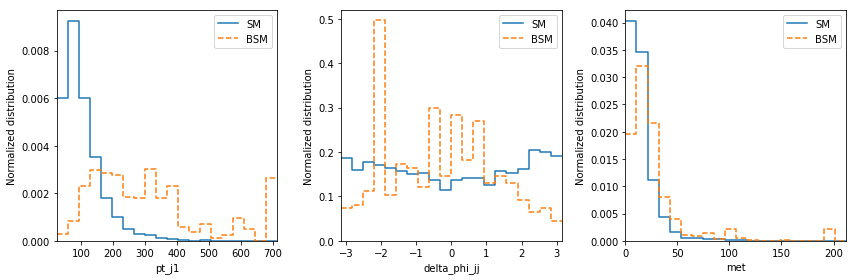

In [14]:
_ = plot_distributions(
    filename='data/delphes_data.h5',
    parameter_points=['sm', np.array([10.,0.])],
    line_labels=['SM', 'BSM'],
    uncertainties='none',
    n_bins=20,
    n_cols=3,
    normalize=True,
)

## 6. Combine and shuffle different samples

To reduce disk usage, you can generate several small event samples with the steps given above, and combine them now. Note that (for now) it is essential that all of them are generated with the same setup, including the same benchmark points / morphing basis!

This is generally good practice even if you use just one sample, since the events might have some inherent ordering (e.g. from sampling from different hypotheses). Later when we split the events into a training and test fraction, such an ordering could cause problems.

In [15]:
combine_and_shuffle(
    ['data/delphes_data.h5'],
    'data/delphes_data_shuffled.h5'
)

16:36 madminer.sampling    DEBUG   Combining and shuffling samples
16:36 madminer.sampling    INFO    Copying setup from data/delphes_data.h5 to data/delphes_data_shuffled.h5
16:36 madminer.sampling    INFO    Loading samples from file 1 / 1 at data/delphes_data.h5, multiplying weights with k factor 1.0
16:36 madminer.sampling    DEBUG   Sampling benchmarks: [0 0 0 ... 0 0 0]
16:36 madminer.sampling    DEBUG   Combined sampling benchmarks: [0 0 0 ... 0 0 0]
16:36 madminer.sampling    DEBUG   Recalculated event numbers per benchmark: [4288    0    0    0    0    0], background: 0
